In [122]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from os import listdir
import timeit
from collections import defaultdict

In [123]:
DIR = 'D:\\Гдиск\\Study\\01.Jupyter\\NLA_face_recognition\\data\\faces\\'

In [124]:
def list_files(directory, contains, remove_duplicates=False):
    if remove_duplicates:
            return list(f for f in listdir(directory) if contains in f and 'pgm' in f)
    return list(f for f in listdir(directory) if contains in f)

In [125]:
def create_dataframe(filenames):
    df = filenames[0].str.split(".", expand=True)
    df["filename"] = filenames

    df = df.rename(columns = {0:"subject", 1:"category"})
    df['subject'] = df.subject.str.replace('subject', '')
    df.apply(pd.to_numeric, errors='coerce').dropna()
    df['subject'] = pd.to_numeric(df["subject"])
    return df

In [126]:
def extract_image_data(df, directory, aggregate_type='None', w=243, h=320):
    '''
    создает np.array со всеми фотографиями и лейблами из директории
    
    '''
    
    if aggregate_type == 'None':
        labels = []
        dataset = np.zeros((w, h, df.shape[0]))
        for i in range(df.shape[0]):
            dataset[:, :, i] = plt.imread(directory + df.iloc[i, 3])
            labels.append(df.iloc[i, 3])
    elif aggregate_type == 'Mean':
        dataset = np.zeros((w, h, df['subject'].nunique()))
        labels = []
        for i in range(df.shape[0]):
            dataset[:, :, df.iloc[i, 0] - 1] += plt.imread(DIR + df.iloc[i, 3])
            label = df.filename.str.split(".", expand=True)[0]
            #if label not in labels:
                #labels.append(label)
        labels = list(np.unique(df.filename.str.split(".", expand=True)[0]))
        dataset = dataset / 11
    elif aggregate_type == 'SVD':
        dataset = np.zeros((w * h, 10, df['subject'].nunique()))
        counter = 0
        for i in range(df.shape[0]):
            if counter > 9:
                counter = 0
                continue
            #print(counter, df.iloc[i, 3])
            dataset[:, counter, df.iloc[i, 0] - 1] = plt.imread(DIR + df.iloc[i, 3]).flatten(order='F')
            
            counter += 1
            
        labels = list(np.unique(df.filename.str.split(".", expand=True)[0]))
        
    return dataset, np.array(labels)

In [127]:
def find_majority(labels):
    '''
    для функции predict, находит наиболее частый элемент
    
    '''
    counter = defaultdict(int)
    for label in labels:
        counter[label] += 1

    # Finding the majority class.
    majority_count = max(counter.values())
    for key, value in counter.items():
        if value == majority_count:
            return key

In [128]:
def predict(data, labels, target, target_label, k):
    '''ранжирует k первых категорий по расстоянию и берет наиболее частую'''
    target_vector = target.flatten(order='F')
    target_name = target_label.split('.')[0]
    
    distances = []
    for i in range(data.shape[2]):
        database_vector = data[:, :, i].flatten(order='F')
        database_label = labels[i].split('.')[0]
        distances.append((np.linalg.norm(target_vector - database_vector), database_label))
    
    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [129]:
def test_predictor(predictor, data, labels, **kwargs):
    '''
    надо либо доделать либо выкинуть
    '''
    counter = 0
    for i in range(data.shape[2]):
        #print(i)
        target = data[:, :, i]
        target_label = labels[i]
        train_data = np.delete(data, i, axis=2)
        train_labels = np.delete(labels, i)
        vector_result = predictor(data=train_data, labels=train_labels, target=target, target_label=target_label, **kwargs)
        if vector_result == target_label.split('.')[0]:
            #print(vector_result, ': True answer')
            counter += 1
    return counter / data.shape[2]

In [130]:
filenames = pd.DataFrame(list_files(DIR, "subject", remove_duplicates=True))

In [131]:
df = create_dataframe(filenames)

In [132]:
df.head(12)

,subject,category,2,filename
0,1,centerlight,pgm,subject01.centerlight.pgm
1,1,glasses,pgm,subject01.glasses.pgm
2,1,happy,pgm,subject01.happy.pgm
3,1,leftlight,pgm,subject01.leftlight.pgm
4,1,noglasses,pgm,subject01.noglasses.pgm
5,1,normal,pgm,subject01.normal.pgm
6,1,rightlight,pgm,subject01.rightlight.pgm
7,1,sad,pgm,subject01.sad.pgm
8,1,sleepy,pgm,subject01.sleepy.pgm
9,1,surprised,pgm,subject01.surprised.pgm


# Наивная реализация  
никакой агрегации на фотографиях, сравнение по l2-норме, датасет не центрированный

In [133]:
data, labels = extract_image_data(df, DIR)

In [134]:
test_predictor(predict, data, labels, k=1 )

0.806060606060606

Центрированный датасет

In [135]:
DIR = 'D:\\Гдиск\\Study\\01.Jupyter\\NLA_face_recognition\\data\\centered\\'

In [136]:
data, labels = extract_image_data(df, DIR, h=195, w=231)

In [137]:
test_predictor(predict, data, labels, k=5 )

0.8484848484848485

# Агрегация по фотографиям - среднее
L2-норма, нецентрированный датасет

In [138]:
DIR = 'D:\\Гдиск\\Study\\01.Jupyter\\NLA_face_recognition\\data\\faces\\'

In [139]:
data, labels = extract_image_data(df, DIR)

In [140]:
mean_data, mean_labels = extract_image_data(df, DIR, 'Mean')

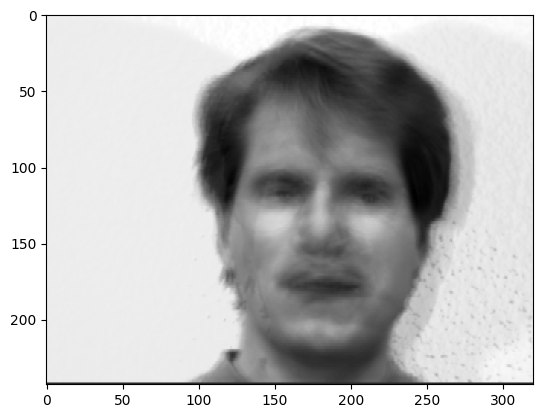

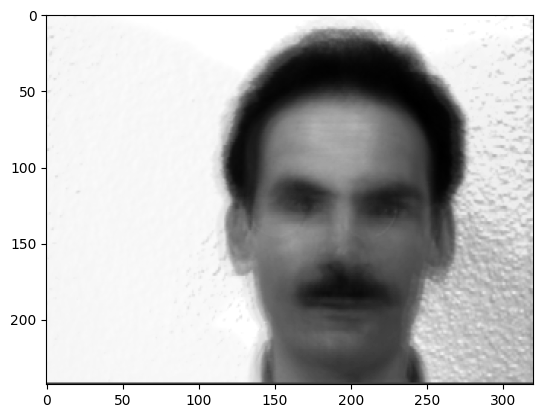

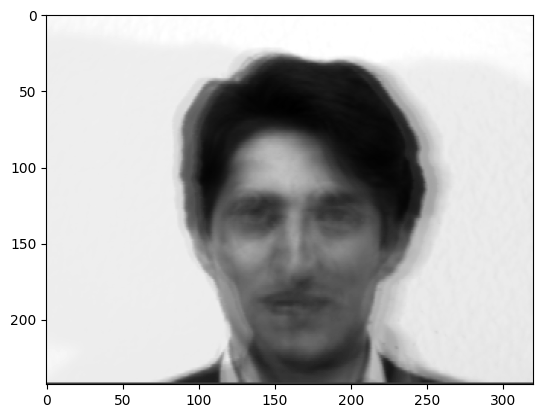

In [141]:
for i in range(3):
    plt.imshow(mean_data[:, :, i],cmap='gray')
    plt.show()

In [142]:
counter = 0
for i in range(df.shape[0]):
    train_data, train_labels = extract_image_data(df.drop(i), DIR, 'Mean')
    #print(i)
    target = data[:, :, i]
    target_label = labels[i]
    
    vector_result = predict(data=train_data, labels=train_labels, target=target, target_label=target_label, k=1)
    
    if vector_result == target_label.split('.')[0]:
        #print(vector_result, ': True answer')
        counter += 1
print(counter / data.shape[2]) 

0.6606060606060606


Центрированный датасет

In [143]:
DIR = 'D:\\Гдиск\\Study\\01.Jupyter\\NLA_face_recognition\\data\\centered\\'

In [144]:
mean_data, mean_labels = extract_image_data(df, DIR, 'Mean', h=195, w=231)

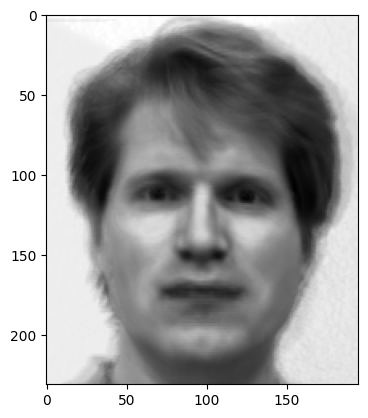

In [145]:
for i in range(1):
    plt.imshow(mean_data[:, :, i],cmap='gray')
    plt.show()

In [146]:
data, labels = extract_image_data(df, DIR, h=195, w=231)

In [147]:
counter = 0
for i in range(df.shape[0]):
    train_data, train_labels = extract_image_data(df.drop(i), DIR, 'Mean', h=195, w=231)
    #print(i)
    target = data[:, :, i]
    target_label = labels[i]
    
    vector_result = predict(data=train_data, labels=train_labels, target=target, target_label=target_label, k=1)
    
    if vector_result == target_label.split('.')[0]:
        #print(vector_result, ': True answer')
        counter += 1
print(counter / data.shape[2]) 

0.8484848484848485


# SVD реализация

In [148]:
DIR = 'D:\\Гдиск\\Study\\01.Jupyter\\NLA_face_recognition\\data\\faces\\'

In [149]:
full_data, full_labels = extract_image_data(df, DIR)

In [150]:
data, labels = extract_image_data(df, DIR, 'SVD')

In [151]:
data.shape

(77760, 10, 15)

In [152]:
labels

array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype='<U9')

In [153]:
U, S, Vh = np.linalg.svd(data[:, :, 4], full_matrices=False)

In [154]:
U.shape

(77760, 10)

In [155]:
U

array([[-2.07374470e-03,  1.14732779e-03,  1.52978170e-03, ...,
        -3.48035701e-04,  4.16009449e-04,  1.52900606e-04],
       [-4.35724055e-03,  1.44159687e-03,  2.50310174e-03, ...,
        -2.79575536e-04,  2.65730093e-04, -6.24296253e-04],
       [-4.39521497e-03,  1.41034340e-03,  2.22720687e-03, ...,
        -4.26739451e-04,  9.43925510e-05, -2.31134422e-04],
       ...,
       [-1.70379240e-03, -3.07418924e-03,  2.95560329e-03, ...,
         3.60890567e-04,  1.77205801e-03,  6.51822160e-04],
       [-1.91254081e-03, -3.29336155e-03,  3.30129357e-03, ...,
         1.03617662e-04,  2.00286404e-03,  8.88743582e-04],
       [-1.20516718e-03, -5.22103665e-04,  2.67817023e-03, ...,
        -1.57414115e-04, -1.90522805e-05, -1.18927426e-04]])

# Колонки матрицы U вычленяют важную ифнормацию из исходной матрицы!

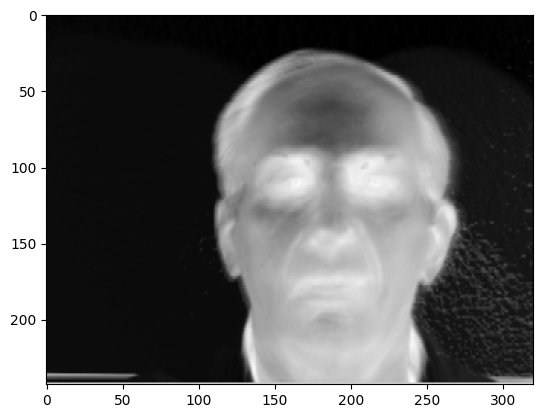

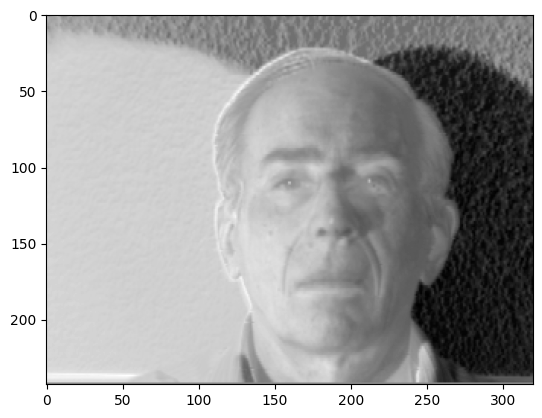

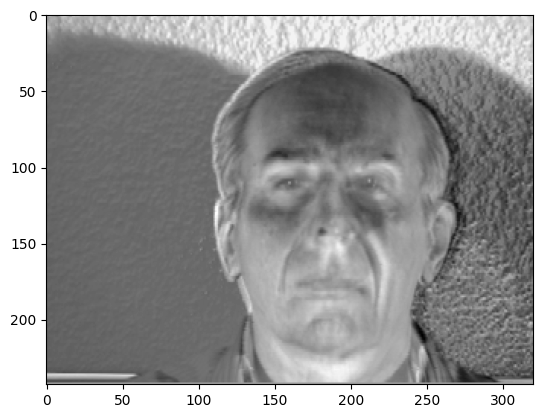

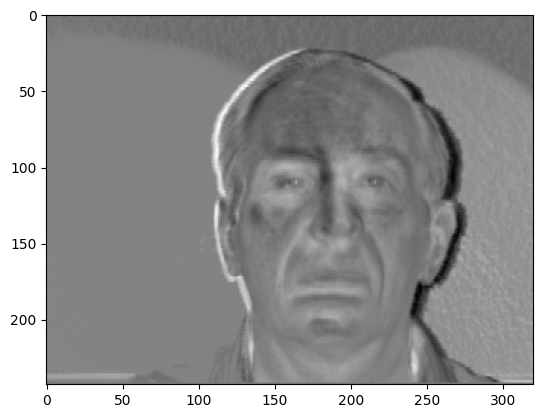

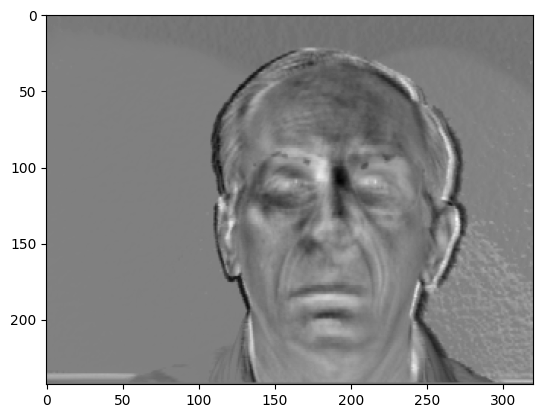

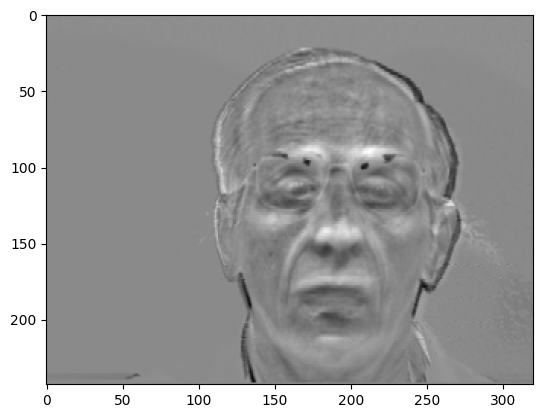

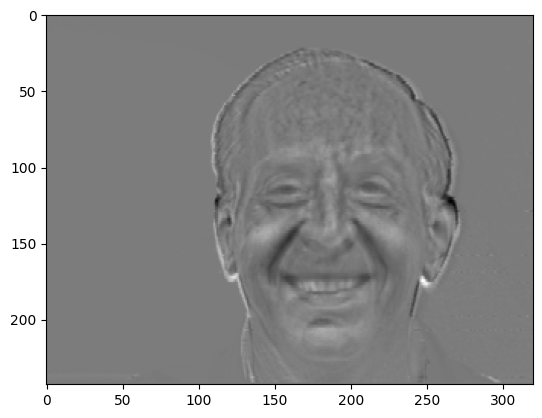

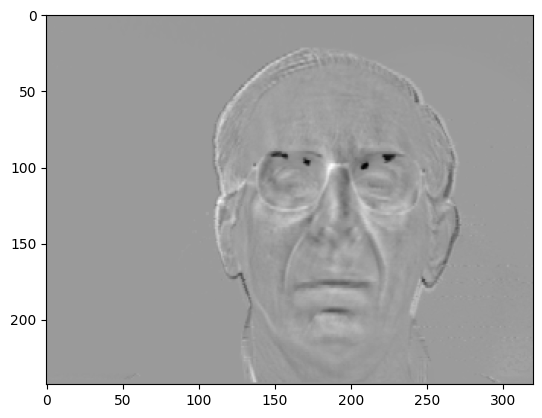

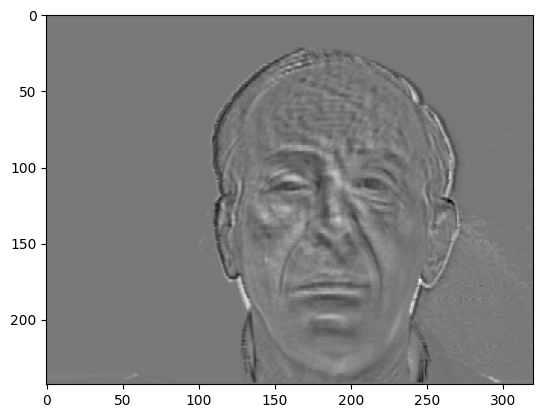

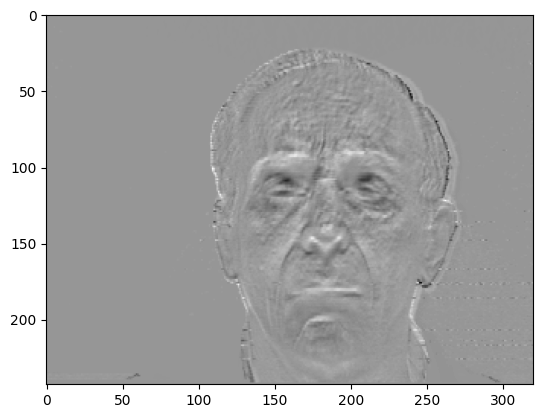

In [156]:
for i in range(10):
    plt.imshow(U[:, i].reshape(320, 243).T,cmap='gray')
    plt.show()

In [157]:
Vh.shape

(10, 10)

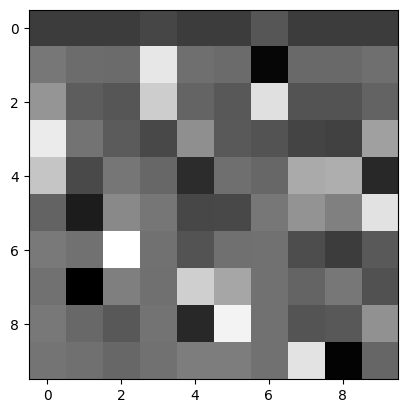

In [158]:
plt.imshow(Vh,cmap='gray')
plt.show()

# Наилучшее приближение искомого фото линейными комбинациями матриц U 
Это Least Squares Problem

In [159]:
U_data = np.zeros(data.shape)
for i in range(data.shape[2]):
    U, S, Vh = np.linalg.svd(data[:, :, i], full_matrices=False)
    print(np.linalg.cond(U))
    U_data[:, :, i] = U
    


1.0000000000001232
1.0000000000000238
1.000000000000133
1.0000000000000582
1.0000000000001001
1.0000000000001732
1.0000000000001885
1.0000000000003304
1.000000000000084
1.0000000000000886
1.000000000000105
1.000000000000066
1.0000000000001548
1.0000000000002447
1.0000000000000486


In [160]:
def predict_svd(data, labels, target, target_label, k):
    '''
    ранжирует k первых категорий по расстоянию и берет наиболее частую
    '''
    
    target_vector = target
    
    norm_target = np.linalg.norm(target_vector)
    target_name = target_label.split('.')[0]
    
    distances = []
    for i in range(data.shape[2]):
        database_matrix = data[:, :, i]
        database_label = labels[i].split('.')[0]
        distances.append((np.linalg.norm((target_vector - database_matrix @ (database_matrix.T @ target_vector)) / norm_target), database_label))
    
    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [161]:
for k in range(1, U_data.shape[1] + 1):
    U_data_train = U_data[:, :k, :]
    counter = 0
    for i in range(1, 16):
        target = full_data[:, :, i * 11 - 1].flatten(order='F')
        target_label = full_labels[i * 11 - 1]
        
        
        vector_result = predict_svd(data=U_data_train, labels=labels, target=target, target_label=target_label, k=1)

        if vector_result == target_label.split('.')[0]:
            counter += 1
    print(counter / 16)

0.8125
0.8125
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375


# SVD на центрированном датасете

In [162]:
DIR = 'D:\\Гдиск\\Study\\01.Jupyter\\NLA_face_recognition\\data\\centered\\'

In [163]:
full_data, full_labels = extract_image_data(df, DIR, w=231, h=195)

In [164]:
data, labels = extract_image_data(df, DIR, 'SVD', w=231, h=195)

In [165]:
U, S, Vh = np.linalg.svd(data[:, :, 4], full_matrices=False)

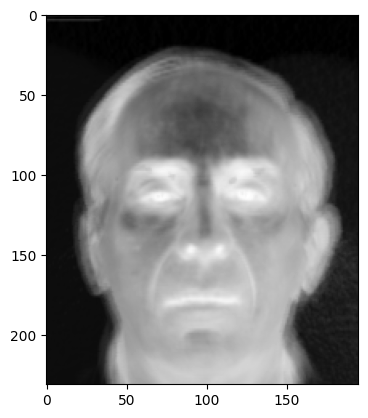

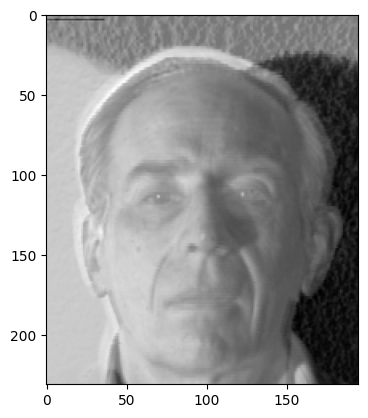

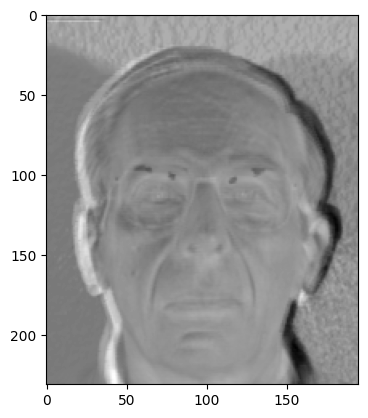

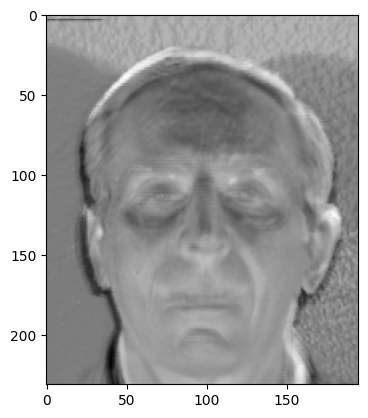

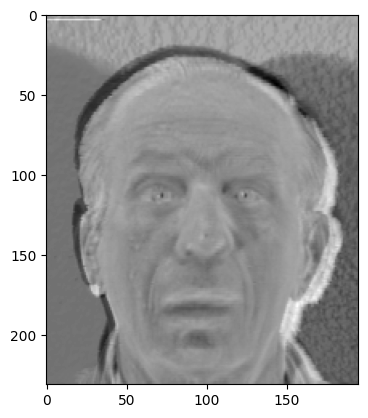

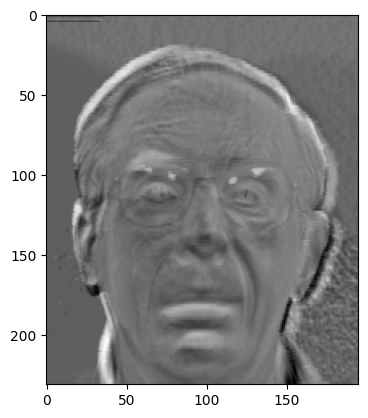

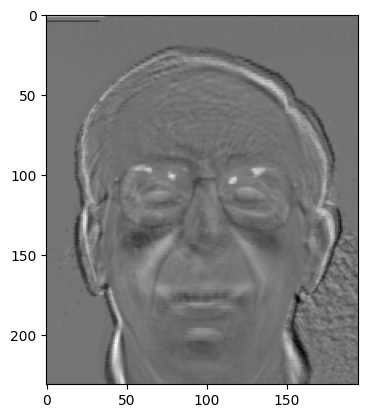

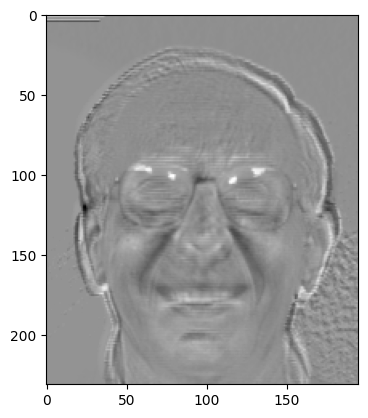

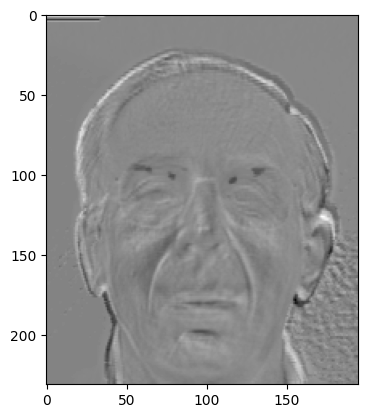

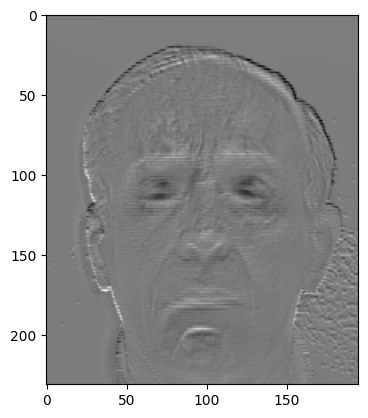

In [166]:
for i in range(10):
    plt.imshow(U[:, i].reshape(195, 231).T,cmap='gray')
    plt.show()

In [167]:
U_data = np.zeros(data.shape)
for i in range(data.shape[2]):
    U, S, Vh = np.linalg.svd(data[:, :, i], full_matrices=False)
    print(np.linalg.cond(U))
    U_data[:, :, i] = U

1.000000000000045
1.000000000000002
1.0000000000000502
1.0000000000000155
1.0000000000000167
1.0000000000000124
1.0000000000000946
1.000000000000062
1.0000000000000564
1.0000000000000449
1.0000000000000062
1.0000000000000169
1.0000000000000682
1.000000000000059
1.0000000000000175


In [168]:
for k in range(1, U_data.shape[1] + 1):
    U_data_train = U_data[:, :k, :]
    counter = 0
    for i in range(1, 16):
        target = full_data[:, :, i * 11 - 1].flatten(order='F')
        target_label = full_labels[i * 11 - 1]

        vector_result = predict_svd(data=U_data_train, labels=labels, target=target, target_label=target_label, k=1)

        if vector_result == target_label.split('.')[0]:
            counter += 1
    print(counter / 16)

0.875
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
